# 27: Deep MLP Classifier Fisher Overlap Analysis

Notebook 26 compared VAE Fisher overlap (7.35M params) against a linear classifier
(462 params). To control for model capacity, this notebook trains a deep MLP
classifier with shared hidden layers (2000 -> [512, 128] -> 14, ~1.09M params)
and computes Fisher overlap separately for the shared hidden layers and the
class-specific output layer.

In [1]:
import sys
sys.path.insert(0, '../src')

import json
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib
from pathlib import Path

from fisher_utils import (
    GeneExprDataset, DeepMLPClassifier,
    compute_classifier_fisher, classifier_layer_category,
    cosine_sim, effective_rank, top_k_overlap,
    vae_layer_category,
)

matplotlib.rcParams['font.size'] = 11
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['axes.linewidth'] = 0.8

OUTPUTS = Path('../outputs')
FIGURES = Path('../figures')
FIGURES.mkdir(exist_ok=True)
(OUTPUTS / 'p6').mkdir(exist_ok=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cpu


## 1. Load data and splits

In [2]:
adata = sc.read_h5ad('../data/adata_processed.h5ad')
print(f'Data: {adata.shape}')

with open(OUTPUTS / 'p1' / 'split_structured.json') as f:
    split = json.load(f)
forget_idx = split['forget_indices']
retain_idx = split['retain_indices']
all_train_idx = forget_idx + retain_idx
print(f'Forget: {len(forget_idx)}, Retain: {len(retain_idx)}, Total: {len(all_train_idx)}')

n_classes = int(adata.obs['leiden'].values[all_train_idx].astype(int).max()) + 1
print(f'Classes: {n_classes}')

Data: (33088, 2000)
Forget: 30, Retain: 28094, Total: 28124
Classes: 14


## 2. Create datasets

In [3]:
all_ds = GeneExprDataset(adata, all_train_idx)
all_loader = DataLoader(all_ds, batch_size=256, shuffle=True)
print(f'Training samples: {len(all_ds)}')

Training samples: 28124


## 3. Initialize deep MLP classifier

In [4]:
torch.manual_seed(42)
np.random.seed(42)

model = DeepMLPClassifier(
    input_dim=2000, hidden_dims=[512, 128],
    n_classes=n_classes, dropout=0.3
).to(device)

n_params = sum(p.numel() for p in model.parameters())
print(f'Deep MLP classifier: {n_params:,} params')
print()
for name, param in model.named_parameters():
    cat = classifier_layer_category(name)
    print(f'  {name:30s} {str(list(param.shape)):20s} {param.numel():>10,d}  [{cat}]')

Deep MLP classifier: 1,093,262 params

  hidden.0.weight                [512, 2000]           1,024,000  [Shared hidden]
  hidden.0.bias                  [512]                       512  [Shared hidden]
  hidden.1.weight                [512]                       512  [Shared hidden]
  hidden.1.bias                  [512]                       512  [Shared hidden]
  hidden.4.weight                [128, 512]               65,536  [Shared hidden]
  hidden.4.bias                  [128]                       128  [Shared hidden]
  hidden.5.weight                [128]                       128  [Shared hidden]
  hidden.5.bias                  [128]                       128  [Shared hidden]
  output.weight                  [14, 128]                 1,792  [Class-specific output]
  output.bias                    [14]                         14  [Class-specific output]


## 4. Train classifier

In [5]:
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-2)
criterion = nn.CrossEntropyLoss()

TARGET_ACC = 0.95
train_losses = []
train_accs = []
start_time = time.time()
final_epoch = 0

for epoch in range(200):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for x_batch, y_batch in all_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        logits = model(x_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(x_batch)
        correct += (logits.argmax(1) == y_batch).sum().item()
        total += len(x_batch)
    avg_loss = total_loss / total
    avg_acc = correct / total
    train_losses.append(avg_loss)
    train_accs.append(avg_acc)
    final_epoch = epoch + 1
    if (epoch + 1) % 10 == 0 or avg_acc >= TARGET_ACC:
        print(f'  Epoch {epoch+1:3d}: loss={avg_loss:.4f}, acc={avg_acc:.4f}')
    if avg_acc >= TARGET_ACC:
        print(f'  -> Reached target accuracy {TARGET_ACC}, stopping.')
        break

elapsed = time.time() - start_time
print(f'\nTraining took {elapsed:.0f}s ({final_epoch} epochs)')

  Epoch   8: loss=0.1791, acc=0.9503
  -> Reached target accuracy 0.95, stopping.

Training took 25s (8 epochs)


## 5. Training curves

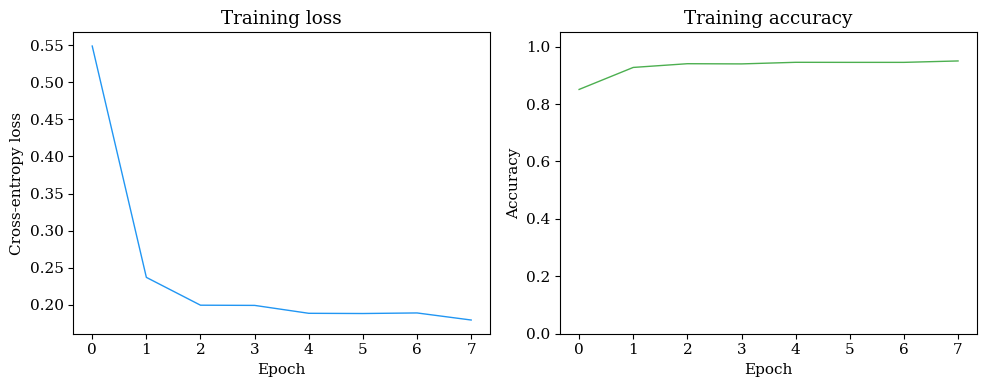

Saved to ../figures/deep_clf_training.png


In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(train_losses, color='#2196F3', linewidth=1)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Cross-entropy loss')
ax1.set_title('Training loss')

ax2.plot(train_accs, color='#4CAF50', linewidth=1)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training accuracy')
ax2.set_ylim(0, 1.05)

plt.tight_layout()
plt.savefig(FIGURES / 'deep_clf_training.png', dpi=150, bbox_inches='tight')
plt.show()
print(f'Saved to {FIGURES / "deep_clf_training.png"}')

## 6. Final accuracy

In [7]:
model.train(False)
test_loader = DataLoader(all_ds, batch_size=512, shuffle=False)
correct = 0
total = 0
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        logits = model(x_batch)
        correct += (logits.argmax(1) == y_batch).sum().item()
        total += len(x_batch)
accuracy = correct / total
print(f'Final training accuracy: {accuracy:.4f}')

Final training accuracy: 0.9519


## 7. Compute Fisher on forget and retain subsets

In [8]:
forget_ds = GeneExprDataset(adata, forget_idx)
retain_ds = GeneExprDataset(adata, retain_idx)
forget_loader = DataLoader(forget_ds, batch_size=128, shuffle=False)
retain_loader = DataLoader(retain_ds, batch_size=256, shuffle=False)

print('Computing forget-set Fisher...')
fisher_forget, n_f = compute_classifier_fisher(model, forget_loader, device)
print(f'  {n_f} samples')

print('Computing retain-set Fisher...')
fisher_retain, n_r = compute_classifier_fisher(model, retain_loader, device)
print(f'  {n_r} samples')

Computing forget-set Fisher...
  30 samples
Computing retain-set Fisher...
  28094 samples


## 8. Per-layer analysis

In [9]:
print(f'{"Layer":40s} {"Params":>10s} {"Cosine":>8s} {"EffRank(F)":>12s} {"EffRank(R)":>12s} {"Category"}')
print('-' * 100)

layer_data = []
categories = {}

for name in fisher_forget:
    ff = fisher_forget[name].flatten()
    fr = fisher_retain[name].flatten()
    n = len(ff)
    cos = cosine_sim(ff, fr)
    er_f = effective_rank(ff)
    er_r = effective_rank(fr)
    cat = classifier_layer_category(name)
    layer_data.append({
        'name': name, 'n_params': n, 'cosine': cos,
        'eff_rank_f': er_f, 'eff_rank_r': er_r, 'category': cat
    })
    if cat not in categories:
        categories[cat] = {'f': [], 'r': []}
    categories[cat]['f'].append(ff)
    categories[cat]['r'].append(fr)
    print(f'{name:40s} {n:10,d} {cos:8.4f} {er_f:12.0f} {er_r:12.0f} {cat}')

Layer                                        Params   Cosine   EffRank(F)   EffRank(R) Category
----------------------------------------------------------------------------------------------------
hidden.0.weight                           1,024,000   0.3013        14832        23876 Shared hidden
hidden.0.bias                                   512   0.3426           68           89 Shared hidden
hidden.1.weight                                 512   0.2032           34           83 Shared hidden
hidden.1.bias                                   512   0.4126           73          114 Shared hidden
hidden.4.weight                              65,536   0.2112         4632        11363 Shared hidden
hidden.4.bias                                   128   0.3654           36           61 Shared hidden
hidden.5.weight                                 128   0.2515           14           68 Shared hidden
hidden.5.bias                                   128   0.4124           38           64 Shared hi

## 9. Global and per-category metrics

In [10]:
# Global metrics
ff_global = torch.cat([f.flatten() for f in fisher_forget.values()])
fr_global = torch.cat([f.flatten() for f in fisher_retain.values()])
global_cos = cosine_sim(ff_global, fr_global)
log_corr = torch.corrcoef(
    torch.stack([ff_global.log(), fr_global.log()])
)[0, 1].item()

print(f'Global cosine similarity: {global_cos:.4f}')
print(f'Log-Fisher correlation:   {log_corr:.4f}')
print()

# Per-category metrics
cat_results = {}
for cat, data in categories.items():
    ff_c = torch.cat(data['f'])
    fr_c = torch.cat(data['r'])
    cat_results[cat] = {
        'cosine': cosine_sim(ff_c, fr_c),
        'n_params': len(ff_c),
        'eff_rank_ratio_forget': effective_rank(ff_c) / len(ff_c),
        'eff_rank_ratio_retain': effective_rank(fr_c) / len(fr_c),
    }
    print(f'{cat:25s}  cosine={cat_results[cat]["cosine"]:.4f}  params={len(ff_c):,}')

Global cosine similarity: 0.0509
Log-Fisher correlation:   0.7522

Shared hidden              cosine=0.2624  params=1,091,456
Class-specific output      cosine=0.0097  params=1,806


## 10. Comparison with NB26 baseline

In [11]:
# Load NB26 canonical results
with open(OUTPUTS / 'p6' / 'fisher_overlap_results.json') as f:
    baseline = json.load(f)

vae_cos = baseline['vae']['global_cosine']
linear_clf_cos = baseline['classifier']['global_cosine']

print(f'{"Model":25s} {"Params":>10s} {"Global cosine":>14s}')
print('=' * 55)
print(f'{"VAE (z=32, NB26)":25s} {baseline["vae"]["total_params"]:10,d} {vae_cos:14.4f}')
print(f'{"Deep MLP classifier":25s} {sum(p.numel() for p in model.parameters()):10,d} {global_cos:14.4f}')
print(f'{"Linear classifier (NB26)":25s} {baseline["classifier"]["total_params"]:10,d} {linear_clf_cos:14.4f}')
print()

# Category-level comparison
print(f'{"Category":25s} {"Deep MLP":>10s} {"VAE equiv.":>12s}')
print('-' * 50)
for cat, r in cat_results.items():
    # Map deep MLP categories to VAE equivalents
    if cat == 'Shared hidden':
        vae_equiv = (baseline['vae']['per_category']['Encoder']['cosine'] +
                     baseline['vae']['per_category']['Decoder hidden']['cosine']) / 2
        vae_label = 'Enc+Dec hid avg'
    else:
        vae_equiv = linear_clf_cos
        vae_label = 'Linear clf'
    print(f'{cat:25s} {r["cosine"]:10.4f} {vae_equiv:12.4f} ({vae_label})')

Model                         Params  Global cosine
VAE (z=32, NB26)           7,349,984         0.3058
Deep MLP classifier        1,093,262         0.0509
Linear classifier (NB26)         462         0.0181

Category                    Deep MLP   VAE equiv.
--------------------------------------------------
Shared hidden                 0.2624       0.2525 (Enc+Dec hid avg)
Class-specific output         0.0097       0.0181 (Linear clf)


## 11. Comparison figure

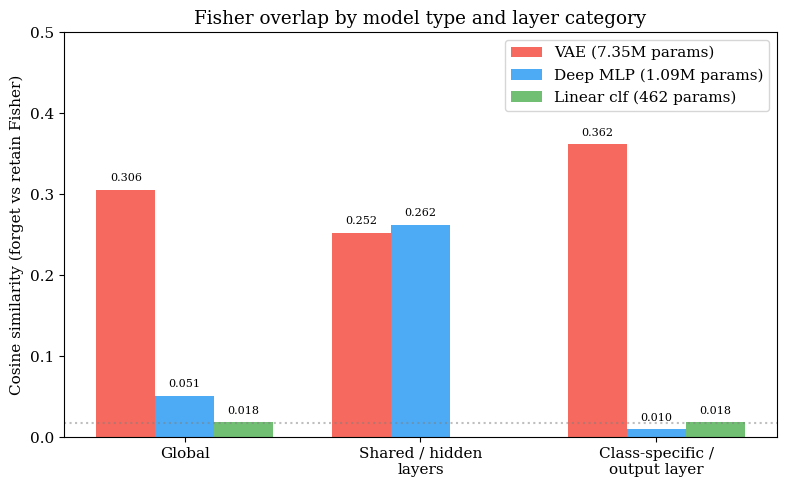

Saved to ../figures/fisher_deep_clf_comparison.png


In [12]:
fig, ax = plt.subplots(figsize=(8, 5))

# Gather data for grouped bar chart
labels = ['Global', 'Shared / hidden\nlayers', 'Class-specific /\noutput layer']

# VAE values
vae_vals = [
    baseline['vae']['global_cosine'],
    # Average of encoder + decoder hidden
    (baseline['vae']['per_category']['Encoder']['cosine'] +
     baseline['vae']['per_category']['Decoder hidden']['cosine']) / 2,
    baseline['vae']['per_category']['Decoder output']['cosine'],
]

# Deep MLP values
deep_vals = [
    global_cos,
    cat_results.get('Shared hidden', {}).get('cosine', 0),
    cat_results.get('Class-specific output', {}).get('cosine', 0),
]

# Linear classifier values
linear_vals = [
    linear_clf_cos,
    np.nan,  # no hidden layers
    linear_clf_cos,
]

x = np.arange(len(labels))
w = 0.25

bars1 = ax.bar(x - w, vae_vals, w, label=f'VAE (7.35M params)', color='#F44336', alpha=0.8)
bars2 = ax.bar(x, deep_vals, w, label=f'Deep MLP ({n_params/1e6:.2f}M params)', color='#2196F3', alpha=0.8)
bars3 = ax.bar(x + w, linear_vals, w, label='Linear clf (462 params)', color='#4CAF50', alpha=0.8)

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel('Cosine similarity (forget vs retain Fisher)')
ax.set_title('Fisher overlap by model type and layer category')
ax.legend(loc='upper right')
ax.set_ylim(0, 0.5)
ax.axhline(y=0.018, color='gray', linestyle=':', alpha=0.5, label='_nolegend_')

# Value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        h = bar.get_height()
        if not np.isnan(h) and h > 0:
            ax.text(bar.get_x() + bar.get_width() / 2, h + 0.008,
                    f'{h:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig(FIGURES / 'fisher_deep_clf_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print(f'Saved to {FIGURES / "fisher_deep_clf_comparison.png"}')

## 12. Save results

In [13]:
results = {
    'model': 'deep_mlp_classifier',
    'architecture': '2000 -> [512, 128] -> 14',
    'total_params': int(n_params),
    'accuracy': accuracy,
    'global_cosine': global_cos,
    'log_fisher_correlation': log_corr,
    'per_category': cat_results,
    'per_layer': layer_data,
    'metadata': {
        'n_forget': len(forget_idx),
        'n_retain': len(retain_idx),
        'damping': 1e-8,
        'hidden_dims': [512, 128],
        'dropout': 0.3,
        'weight_decay': 1e-2,
        'target_accuracy': TARGET_ACC,
        'epochs': final_epoch,
        'lr': 1e-3,
        'elapsed_seconds': elapsed,
    }
}

out_path = OUTPUTS / 'p6' / 'fisher_overlap_deep_clf.json'
with open(out_path, 'w') as f:
    json.dump(results, f, indent=2, default=float)
print(f'Results saved to {out_path}')
print()
print('=== Summary ===')
print(f'Deep MLP global cosine:   {global_cos:.4f}')
print(f'VAE global cosine (NB26): {vae_cos:.4f}')
print(f'Linear clf cosine (NB26): {linear_clf_cos:.4f}')
print(f'Shared hidden cosine:     {cat_results["Shared hidden"]["cosine"]:.4f}')
print(f'Class-specific cosine:    {cat_results["Class-specific output"]["cosine"]:.4f}')

Results saved to ../outputs/p6/fisher_overlap_deep_clf.json

=== Summary ===
Deep MLP global cosine:   0.0509
VAE global cosine (NB26): 0.3058
Linear clf cosine (NB26): 0.0181
Shared hidden cosine:     0.2624
Class-specific cosine:    0.0097
